In [1]:
import uuid
from dotenv import load_dotenv
from modules import logging
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.schema import BaseMessage
from typing_extensions import Annotated, Literal, Sequence, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import pprint
from langchain_core.runnables import RunnableConfig

In [2]:
from dotenv import load_dotenv
from modules import logging

In [3]:
# LangSmith Logging
logging.langsmith("Model_RAG")
# API 키 정보 로드
load_dotenv()

LangSmith 추적을 시작합니다.
[프로젝트명]
Model_RAG


True

In [4]:
session_id = str(uuid.uuid4())

In [5]:
memory = MemorySaver()

In [6]:
ollama_embeddings = OllamaEmbeddings(
    model="nomic-embed-text"
)

loaded_db = FAISS.load_local(
    folder_path="faiss_db",
    index_name="meritz_index",
    embeddings=ollama_embeddings,
    allow_dangerous_deserialization=True,
)

C:\Users\vkxql\AppData\Local\Temp\ipykernel_15984\4185708034.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(


In [7]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [8]:
# MultiQueryRetriever 설정
multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=loaded_db.as_retriever(),
    llm=llm
)

In [9]:
class state(TypedDict):
    # 메시지 관리 (사용자와 시스템의 대화 기록)
    messages: Annotated[Sequence[BaseMessage], "add_messages"]
    # 세션 ID (각 워크플로우 인스턴스에 고유한 ID)
    session_id: str
    # 기타 메타데이터 (사용자 정보, 소스 등)
    metadata: dict
    # 검색된 문서 리스트
    retrieved_docs: list  # 검색 결과 (MultiQueryRetriever의 반환 값)
    # 재 생성 된 답변
    rewritten_question : list
    # 생성된 최종 답변
    generated_response: str  # 시스템의 최종 답변

## 노드

In [10]:
# Agent 노드

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    # model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    state["messages"] = response
    return state

In [11]:
def retriever_tool(state:state) -> state:
    """
    Retrieves documents using MultiQueryRetriever based on the current question.
    """
    print("---CALL RETRIEVE TOOL---")
    
    # 사용자의 마지막 질문 또는 rewritten_question이 있는 경우 해당 값을 사용
    user_question = state["rewritten_question"] if "rewritten_question" in state and state["rewritten_question"] else state["messages"][-1]["content"]

    
    # MultiQueryRetriever에 사용할 프롬프트
    multi_query_prompt = f"""
    You are an expert assistant trained to optimize search queries for retrieving the most relevant documents.
    Given a user question, your task is to generate multiple rephrased versions of the same question. These
    rephrased questions should:
    
    1. Cover different ways a user might phrase the same question.
    2. Maintain the original intent and meaning of the question.
    3. Use synonyms, structural variations, and alternative expressions where applicable.

    For the following user question, generate at least **5 rephrased versions**:
    
    Original Question:
    "{user_question}"
    
    Ensure your rephrased versions are concise, clear, and ready to be used in a search query. Output the rephrased questions as a list.
    """
    
    # MultiQueryRetriever로 문서 검색
    retrieved_docs = multi_query_retriever.get_relevant_documents(multi_query_prompt)
    
    # 검색된 문서를 상태에 저장
    state["retrieved_docs"] = retrieved_docs
    return state

In [12]:
def grade_documents(state: state) -> state:
    """
    Grades the retrieved documents to determine relevance to the user's question.
    """
    print("---GRADE DOCUMENTS NODE ACTIVATED---")
    
    retrieved_docs = state.get("retrieved_docs", [])
    current_question = state["current_question"]
    
    grading_prompt = f"""
    You are an expert in evaluating document relevance. Given the user's question and the retrieved documents,
    evaluate whether the documents are relevant or not.

    User Question:
    "{current_question}"

    Retrieved Documents (Summarized):
    {retrieved_docs}

    Respond with:
    - "Relevant" if the documents are relevant to the question.
    - "Not Relevant" if the documents are not relevant.
    """
    
    # LLM 평가
    relevance_result = llm(grading_prompt)
    state["document_grading"] = relevance_result.strip().lower()
    print(f"Document Grading: {state['document_grading']}")
    return state


In [13]:
def rewrite(state: state) -> state:
    """
    Generates a new question if the retrieved documents are not relevant.
    """
    print("---REWRITE NODE ACTIVATED---")
    
    current_question = state["current_question"]
    rewrite_prompt = f"""
    The retrieved documents were not relevant to the following user question:
    "{current_question}"
    
    Please analyze the user's intent and generate a new question that better represents the user's intent
    to find relevant documents. Ensure the new question is concise and clear.
    """
    
    # LLM을 사용하여 질문 재작성
    rewritten_question = llm(rewrite_prompt)
    state["rewritten_question"] = rewritten_question.strip()
    print(f"Rewritten Question: {state['rewritten_question']}")
    return state


In [14]:
# 답변 생성 노드

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    # prompt = hub.pull("rlm/rag-prompt")
    # print(prompt)
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. \n
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know.
        Use three sentences maximum and keep the answer concise.
        """
    )

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [15]:
workflow = StateGraph(state)

In [16]:
workflow.add_node("agent", agent)
workflow.add_node("retriever_tool", retriever_tool)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

In [17]:
# 노드 간 기본 연결
workflow.add_edge(START, "agent")
workflow.add_edge("agent", "retriever_tool")
workflow.add_edge("retriever_tool", "grade_documents")

# 조건부 연결 추가
def conditional_decision(state):
    """
    조건부 경로를 결정하는 함수.
    'grade_documents' 결과에 따라 경로가 나뉨.
    """
    if state.get("document_grading") == "relevant":
        return "generate"
    else:
        return "rewrite"

workflow.add_conditional_edges(
    "grade_documents",
    
    conditional_decision,  # 조건 함수
     path_map={
        "generate": "generate",     # Generate로 이어지는 경우 END로 연결
        "rewrite": "rewrite"   # Rewrite로 이어지는 경우 Agent로 루프
    }
)
# 다른 연결 추가
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "retriever_tool")

In [18]:
graph = workflow.compile(checkpointer=memory)

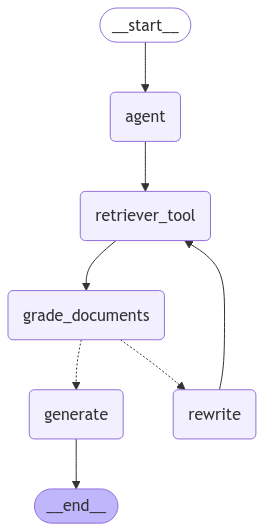

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
inputs = {
    "messages": [
        ("user", "대인 부분 약관과 보장 범위에 대해 알려줘."),
    ]
}

In [21]:
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"}, # 스레드 ID 설정
    tags=["my-tag"], # Tag
)

In [22]:
ㅇㅇㅇㅇ

NameError: name 'ᄋᄋᄋᄋ' is not defined